In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score
from mlflow.tracking import MlflowClient
import mlflow
import mlflow.sklearn
import itertools
import os
import json

# MLflow Config
mlflow.set_tracking_uri("http://127.0.0.1:8100")
EXPERIMENT_NAME = "iris_poisoning_experiment_v3"
REGISTERED_MODEL_NAME = "Iris_Poison_V3"

# ------------------------------------------------------------
# 1. DATA POISONING FUNCTION
# ------------------------------------------------------------
def poison_data_random(X, fraction):
    """
    Replace 'fraction' of rows in X with random noise.
    Noise is drawn from column-wise min/max ranges of the data.
    """
    X_poisoned = X.copy()
    n = len(X)
    k = int(n * fraction)

    if k == 0:
        return X_poisoned, []

    # Randomly choose rows to poison by position
    poisoned_idx = np.random.choice(n, size=k, replace=False)

    for col in X.columns:
        col_min, col_max = X[col].min(), X[col].max()
        X_poisoned.iloc[poisoned_idx, X.columns.get_loc(col)] = \
            np.random.uniform(col_min, col_max, size=k)

    return X_poisoned, poisoned_idx.tolist()

# ------------------------------------------------------------
# 2. TRAINING FUNCTION FOR EACH POISON LEVEL
# ------------------------------------------------------------
def run_experiment_with_poison(X_train, y_train, X_eval, y_eval, poison_level, client):
    """
    Runs hyperparameter tuning for a given level of data poisoning.
    Logs everything to MLflow.
    """
    print(f"\n========== Running Experiment: Poison Level {poison_level*100}% ==========")

    # Apply poisoning
    X_train_poison, poisoned_idx = poison_data_random(X_train, poison_level)

    # Save poisoned samples for logging
    poison_info = {
        "poison_fraction": poison_level,
        "num_poisoned_rows": len(poisoned_idx),
        "poisoned_indices": poisoned_idx
    }

    # Parameter search space
    param_grid = {
        "n_estimators": [50],
        "max_depth": [None],
        "max_features": ["sqrt"]
    }

    best_val = -1.0
    best_run_id = None
    best_params = None

    for combo in itertools.product(*param_grid.values()):
        params = dict(zip(param_grid.keys(), combo))

        with mlflow.start_run(run_name=f"poison_{int(poison_level*100)}"):

            # Log poison metadata
            mlflow.log_param("poison_fraction", poison_level)
            mlflow.log_dict(poison_info, "poison_info.json")

            # Log model hyperparameters
            mlflow.log_params(params)

            # Train model
            clf = RandomForestClassifier(random_state=42, **params)
            clf.fit(X_train_poison, y_train)
            preds = clf.predict(X_eval)

            # Metrics
            acc = accuracy_score(y_eval, preds)
            prec = precision_score(y_eval, preds, average="weighted")
            f1 = f1_score(y_eval, preds, average="weighted")

            mlflow.log_metric("val_accuracy", acc)
            mlflow.log_metric("precision", prec)
            mlflow.log_metric("f1_score", f1)

            # Log model
            mlflow.sklearn.log_model(clf, "model")

            # Track best run
            run_id = mlflow.active_run().info.run_id
            if acc > best_val:
                best_val = acc
                best_run_id = run_id
                best_params = params

    # Register best model
    print(f"Best accuracy for {poison_level*100}% poison = {best_val}")
    print("Best params =", best_params)

    result = mlflow.register_model(f"runs:/{best_run_id}/model", REGISTERED_MODEL_NAME)
    print("Registered model version:", result.version)
    return best_val



file_path = 'iris.csv'
df = pd.read_csv(file_path)

X = df.drop("species", axis=1)
y = df["species"]

# Train-test split
X_train, X_eval, y_train, y_eval = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Ensure MLflow experiment exists
client = MlflowClient()
exp = client.get_experiment_by_name(EXPERIMENT_NAME)
if exp is None:
    client.create_experiment(EXPERIMENT_NAME)

mlflow.set_experiment(EXPERIMENT_NAME)

# -------------------------------------
# Run for baseline + poisoning levels
# -------------------------------------
poison_levels = [0.0, 0.05, 0.10, 0.50]
results = {}
for p in poison_levels:
    results[p]=run_experiment_with_poison(X_train, y_train, X_eval, y_eval, p, client)



========== Running Experiment: Poison Level 0.0% ==========


2025/11/16 17:02:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/16 17:02:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Iris_Poison_V3'.
2025/11/16 17:02:42 WARNING mlflow.tracking._model_registry.fluent: Run with id d926c98bb7c747529ce44aa2f0bb7313 has no artifacts at artifact path 'model', registering model based on models:/m-a125a421dc5f4d6cb8f214aaa358d9ee instead
2025/11/16 17:02:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Iris_Poison_V3, version 1


🏃 View run poison_0 at: http://127.0.0.1:8100/#/experiments/954449433468319355/runs/d926c98bb7c747529ce44aa2f0bb7313
🧪 View experiment at: http://127.0.0.1:8100/#/experiments/954449433468319355
Best accuracy for 0.0% poison = 0.9047619047619048
Best params = {'n_estimators': 50, 'max_depth': None, 'max_features': 'sqrt'}


Created version '1' of model 'Iris_Poison_V3'.
2025/11/16 17:02:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Registered model version: 1

========== Running Experiment: Poison Level 5.0% ==========


2025/11/16 17:02:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Iris_Poison_V3' already exists. Creating a new version of this model...
2025/11/16 17:02:46 WARNING mlflow.tracking._model_registry.fluent: Run with id 8c3f389e22e04941978134206b6bf83e has no artifacts at artifact path 'model', registering model based on models:/m-00df8a0747fe4ac9888f44834d3a0e5f instead
2025/11/16 17:02:46 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Iris_Poison_V3, version 2
Created version '2' of model 'Iris_Poison_V3'.


🏃 View run poison_5 at: http://127.0.0.1:8100/#/experiments/954449433468319355/runs/8c3f389e22e04941978134206b6bf83e
🧪 View experiment at: http://127.0.0.1:8100/#/experiments/954449433468319355
Best accuracy for 5.0% poison = 0.8571428571428571
Best params = {'n_estimators': 50, 'max_depth': None, 'max_features': 'sqrt'}
Registered model version: 2

========== Running Experiment: Poison Level 10.0% ==========


2025/11/16 17:02:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/16 17:02:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Iris_Poison_V3' already exists. Creating a new version of this model...
2025/11/16 17:02:50 WARNING mlflow.tracking._model_registry.fluent: Run with id c559c3f7c5784b8db2b6cde338ad471a has no artifacts at artifact path 'model', registering model based on models:/m-b6089f5599084101baf9e56385f7cb48 instead
2025/11/16 17:02:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Iris_Poison_V3, version 3


🏃 View run poison_10 at: http://127.0.0.1:8100/#/experiments/954449433468319355/runs/c559c3f7c5784b8db2b6cde338ad471a
🧪 View experiment at: http://127.0.0.1:8100/#/experiments/954449433468319355
Best accuracy for 10.0% poison = 0.9047619047619048
Best params = {'n_estimators': 50, 'max_depth': None, 'max_features': 'sqrt'}
Registered model version: 3

========== Running Experiment: Poison Level 50.0% ==========


Created version '3' of model 'Iris_Poison_V3'.
2025/11/16 17:02:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/16 17:02:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Iris_Poison_V3' already exists. Creating a new version of this model...
2025/11/16 17:02:54 WARNING mlflow.tracking._model_registry.fluent: Run with id 69d028a1a950426f87b4fcee072dec98 has no artifacts at artifact path 'model', registering model based on models:/m-5d5f79d337894cd2b41b25df3df56ef3 instead
2025/11/16 17:02:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Iris_Poison_V3, version 4
Created version '4' of model 'Iris_Poison_V3'.


🏃 View run poison_50 at: http://127.0.0.1:8100/#/experiments/954449433468319355/runs/69d028a1a950426f87b4fcee072dec98
🧪 View experiment at: http://127.0.0.1:8100/#/experiments/954449433468319355
Best accuracy for 50.0% poison = 0.8571428571428571
Best params = {'n_estimators': 50, 'max_depth': None, 'max_features': 'sqrt'}
Registered model version: 4


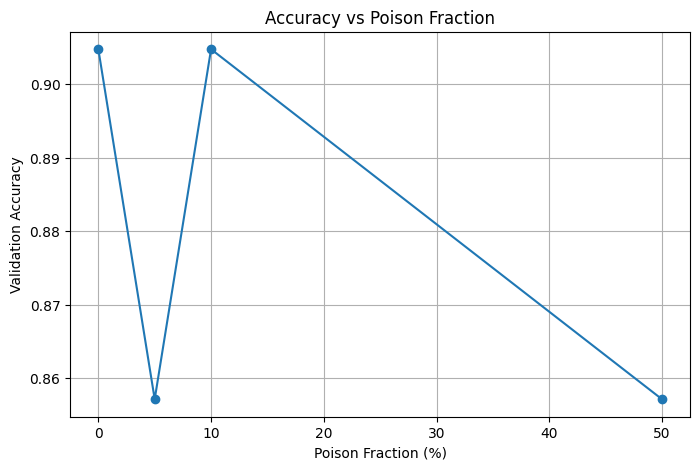

In [2]:
import matplotlib.pyplot as plt

# Plot graph
plt.figure(figsize=(8, 5))
plt.plot([p * 100 for p in results.keys()], list(results.values()), marker='o')
plt.title("Accuracy vs Poison Fraction")
plt.xlabel("Poison Fraction (%)")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()


In [3]:
print(results)

{0.0: 0.9047619047619048, 0.05: 0.8571428571428571, 0.1: 0.9047619047619048, 0.5: 0.8571428571428571}
